In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Load the dataset from the Google drive
!unzip '/content/drive/MyDrive/DLAssignment/flights_sample_3m.csv 1.zip'

# Load the CSV file after unzipping
data = pd.read_csv('/content/flights_sample_3m.csv')

Archive:  /content/drive/MyDrive/DLAssignment/flights_sample_3m.csv 1.zip
  inflating: flights_sample_3m.csv   


In [45]:
# checking the dataset
data.head(5)

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [46]:
# Filter only delayed flights
data = data[data['ARR_DELAY'] > 0]

In [47]:
# Check the dataset shape
data.shape

(978147, 32)

In [48]:
# Check the data types of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978147 entries, 3 to 2999997
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  978147 non-null  object 
 1   AIRLINE                  978147 non-null  object 
 2   AIRLINE_DOT              978147 non-null  object 
 3   AIRLINE_CODE             978147 non-null  object 
 4   DOT_CODE                 978147 non-null  int64  
 5   FL_NUMBER                978147 non-null  int64  
 6   ORIGIN                   978147 non-null  object 
 7   ORIGIN_CITY              978147 non-null  object 
 8   DEST                     978147 non-null  object 
 9   DEST_CITY                978147 non-null  object 
 10  CRS_DEP_TIME             978147 non-null  int64  
 11  DEP_TIME                 978147 non-null  float64
 12  DEP_DELAY                978147 non-null  float64
 13  TAXI_OUT                 978147 non-null  float64
 14  WHEELS_O

In [49]:
# Function to encode categorical data
def encode_categorical_columns(list_of_labels, data):
    label_encoders = {label: LabelEncoder() for label in list_of_labels}

    for label in list_of_labels:
        data[label] = label_encoders[label].fit_transform(data[label])

    return data

In [50]:
# Function to process time columns
def convert_time_columns(data):
    # Extract hour and minute for CRS departure and arrival times
    data['CRS_DEP_HOUR'] = data['CRS_DEP_TIME'].apply(lambda x: x // 100)
    data['CRS_DEP_MINUTE'] = data['CRS_DEP_TIME'].apply(lambda x: x % 100)
    data['CRS_ARR_HOUR'] = data['CRS_ARR_TIME'].apply(lambda x: x // 100)
    data['CRS_ARR_MINUTE'] = data['CRS_ARR_TIME'].apply(lambda x: x % 100)

    data['DEP_TIME_PERIOD'] = pd.qcut(data['CRS_DEP_HOUR'], q=4, labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    return data

In [51]:
# Function to process flight data
def extract_date_features(data):
    data['FL_DATE'] = pd.to_datetime(data['FL_DATE'], errors='coerce')
    data['DayOfWeek'] = data['FL_DATE'].dt.dayofweek
    data['Month'] = data['FL_DATE'].dt.month
    data['Day'] = data['FL_DATE'].dt.day

    data = convert_time_columns(data)
    return data

In [52]:
data = extract_date_features(data)

In [53]:
# Drop columns that are not relevant to the prediction
data = data.drop(['CANCELLED', 'CANCELLATION_CODE', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN','DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY','DELAY_DUE_LATE_AIRCRAFT', 'DOT_CODE', 'AIRLINE_CODE', 'ORIGIN_CITY', 'DEST_CITY','AIRLINE_DOT',
    'FL_NUMBER', 'DIVERTED', 'FL_DATE'], axis=1)

In [54]:
# Clean the labels
list_of_labels = ['AIRLINE', 'ORIGIN', 'DEST', 'DEP_TIME_PERIOD']
data = encode_categorical_columns(list_of_labels, data)

# Handle missing values by filling them with the mean
data.fillna(data.mean(), inplace=True)

In [55]:
data.head(10)

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,...,AIR_TIME,DISTANCE,DayOfWeek,Month,Day,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
3,3,247,325,1609,1608.0,-1.0,1829,1853.0,24.0,260.0,...,249.0,1589.0,0,3,6,16,9,18,29,0
5,15,93,257,1010,1237.0,147.0,1110,1331.0,141.0,60.0,...,36.0,181.0,2,7,31,10,10,11,10,3
7,13,167,96,1643,1637.0,-6.0,1945,2008.0,23.0,122.0,...,88.0,613.0,0,7,8,16,43,19,45,0
9,0,323,125,2125,2116.0,-9.0,2355,2356.0,1.0,210.0,...,198.0,1533.0,5,8,22,21,25,23,55,1
10,3,23,31,1850,1959.0,69.0,2112,2212.0,60.0,142.0,...,115.0,859.0,4,6,11,18,50,21,12,0
12,15,226,47,820,826.0,6.0,940,941.0,1.0,80.0,...,59.0,395.0,3,8,5,8,20,9,40,3
15,15,61,31,1735,1738.0,3.0,1840,1846.0,6.0,65.0,...,53.0,283.0,6,5,1,17,35,18,40,0
19,17,343,261,1615,1611.0,-4.0,1815,1850.0,35.0,180.0,...,176.0,1050.0,6,3,17,16,15,18,15,0
21,16,131,8,1430,1443.0,13.0,1700,1711.0,11.0,150.0,...,115.0,977.0,6,1,27,14,30,17,0,2
23,2,100,284,830,830.0,0.0,1014,1020.0,6.0,104.0,...,87.0,604.0,1,9,6,8,30,10,14,3


In [68]:
# Split data into features (X) and target (y)
X = data.drop(columns=['ARR_DELAY'])
y = data['ARR_DELAY']

In [69]:
# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, shuffle=False)

In [70]:
# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Convert target to numpy and reshape
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [71]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [72]:
# Define the RNN model architecture
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [74]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val), verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/15
3745/3745 - 19s - 5ms/step - loss: 0.0034 - mae: 0.0292 - val_loss: 7.2128e-04 - val_mae: 0.0129
Epoch 2/15
3745/3745 - 9s - 3ms/step - loss: 5.6292e-04 - mae: 0.0142 - val_loss: 1.2895e-04 - val_mae: 0.0078
Epoch 3/15
3745/3745 - 11s - 3ms/step - loss: 2.0848e-04 - mae: 0.0097 - val_loss: 8.8045e-05 - val_mae: 0.0074
Epoch 4/15
3745/3745 - 8s - 2ms/step - loss: 1.3519e-04 - mae: 0.0078 - val_loss: 4.5232e-05 - val_mae: 0.0049
Epoch 5/15
3745/3745 - 10s - 3ms/step - loss: 9.6000e-05 - mae: 0.0067 - val_loss: 2.2648e-05 - val_mae: 0.0033
Epoch 6/15
3745/3745 - 12s - 3ms/step - loss: 6.6482e-05 - mae: 0.0055 - val_loss: 1.4202e-05 - val_mae: 0.0025
Epoch 7/15
3745/3745 - 8s - 2ms/step - loss: 4.7951e-05 - mae: 0.0045 - val_loss: 7.9338e-06 - val_mae: 0.0017
Epoch 8/15
3745/3745 - 13s - 3ms/step - loss: 3.4383e-05 - mae: 0.0036 - val_loss: 5.7066e-06 - val_mae: 0.0014
Epoch 9/15
3745/3745 - 10s - 3ms/step - loss: 2.7476e-05 - mae: 0.0031 - val_loss: 2.7226e-06 - val_mae: 0.0010

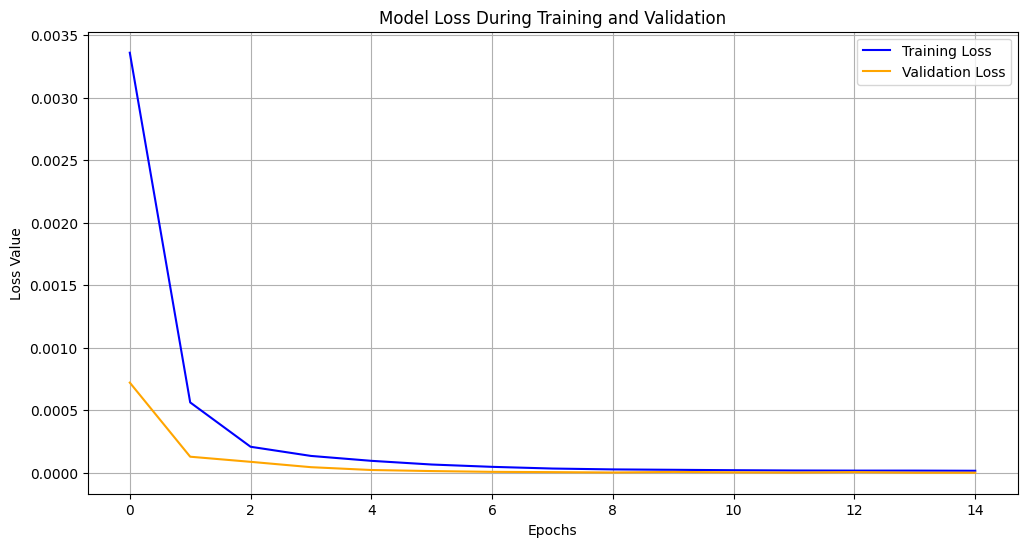

In [75]:
# Plot training and validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Model Loss During Training and Validation')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

Test loss (MSE): 9.420958235750732e-07
Test MAE: 0.0004904871457256377


In [77]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and true values
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Calculate Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate accuracy
accuracy = 100 - mape

9171/9171 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


In [78]:
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 18.88%
Accuracy: 81.12%


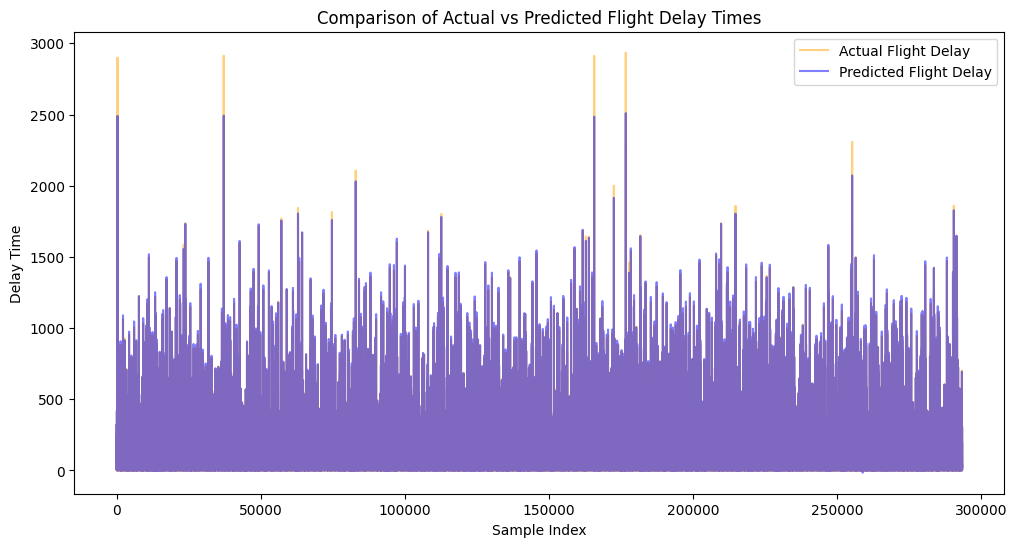

In [79]:
# Plot of Predictions Compared to Actual Values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Flight Delay', color='orange', alpha=0.5)
plt.plot(y_pred, label='Predicted Flight Delay', color='blue', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Delay Time')
plt.title('Comparison of Actual vs Predicted Flight Delay Times')
plt.legend()
plt.show()